In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn import ensemble #ансамбли

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lets read the file

In [4]:
data = pd.read_csv('/content/drive/MyDrive/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Checking information about columns and data types

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


Looking for missing values

In [6]:
data.isna().sum().sort_values()

Activity    0
D1190       0
D1189       0
D1188       0
D1187       0
           ..
D586        0
D585        0
D584        0
D595        0
D1776       0
Length: 1777, dtype: int64

The number of 1 and 0 values in our target column is not equal. It would be better to stratify the split.

In [7]:
data['Activity'].value_counts()

1    2034
0    1717
Name: Activity, dtype: int64

Creating matrix of observations X and vector of  answers y

In [8]:
X = data.drop(columns='Activity')
y = data['Activity']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

# Logistic regression

Basic logistic regression model

In [10]:
log_reg = linear_model.LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print(f'Accuracy score on test data: {round(log_reg.score(X_test, y_test), 2)}')
print(f'F-1 score on test data: {round(metrics.f1_score(y_test, y_test_pred), 2)}')

Accuracy score on test data: 0.75
F-1 score on test data: 0.78


### GridSearchCV

Testing grid search

In [11]:
param_grid = {'penalty': ['l2', 'none'],
              'solver': ['lbfgs', 'saga']
              }

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

%time grid_search.fit(X_train, y_train) 
print(f'Accuracy score on test data: {round(grid_search.score(X_test, y_test), 2)}')
y_test_pred = grid_search.predict(X_test)
print(f'F-1 score on test data: {round(metrics.f1_score(y_test, y_test_pred), 2)}')
print(f'Best values of hyperparameters: {grid_search.best_params_}')

CPU times: user 7.88 s, sys: 1.45 s, total: 9.33 s
Wall time: 8min 20s
Accuracy score on test data: 0.75
F-1 score on test data: 0.78
Best values of hyperparameters: {'penalty': 'l2', 'solver': 'lbfgs'}


In [12]:
print(f'Наилучшая модель:\n{grid_search.best_estimator_}')

Наилучшая модель:
LogisticRegression(max_iter=1000, random_state=42)


No luck in finding better parameters in this case.

### RandomizedSearchCV

In [13]:
param_distributions = {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
              'C': list(np.linspace(0.01, 1, 10, dtype=float))}

random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_distributions,
    cv=5,
    n_iter=10,
    n_jobs=-1
)
%time random_search.fit(X_train, y_train)
print(f'Accuracy score on test data: {round(random_search.score(X_test, y_test), 2)}')
y_test_pred = random_search.predict(X_test)
print(f'F-1 score on test data: {round(metrics.f1_score(y_test, y_test_pred), 2)}')
print(f'Best values of hyperparameters: {random_search.best_params_}')

CPU times: user 4.93 s, sys: 678 ms, total: 5.6 s
Wall time: 15min 39s
Accuracy score on test data: 0.75
F-1 score on test data: 0.78
Best values of hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.23}


Randomized search didn't work as well.

# Random Forest

In [24]:
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
print(f'Accuracy score on test data: {round(rf.score(X_test, y_test), 2)}')
print(f'F-1 score on test data: {round(metrics.f1_score(y_test, y_test_pred), 2)}')

Accuracy score on test data: 0.79
F-1 score on test data: 0.8


Basic random forest showed better result that logistic regression with optimized hyperparameters

### Hyperopt

In [14]:
!pip install hyperopt
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
print("Версия Hyperopt : {}".format(hyperopt.__version__))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Версия Hyperopt : 0.2


In [25]:
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [26]:
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }

    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    model.fit(X, y)
    # using cross validation for scoring
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

In [27]:
%%time

trials = Trials() 

best=fmin(hyperopt_rf, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20, 
          trials=trials, 
          rstate=np.random.RandomState(random_state) 
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [03:32<00:00, 10.63s/it, best loss: -0.8157677360251723]
Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 153.0}
CPU times: user 51 s, sys: 789 ms, total: 51.8 s
Wall time: 3min 32s


In [28]:
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


We've managed to improve f1 metric using hyperopt. Lets try to make more iterations (50) and check if it helps to increase meric further

In [29]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 30/30 [05:00<00:00, 10.03s/it, best loss: -0.8201817887271053]
Наилучшие значения гиперпараметров {'max_depth': 16.0, 'min_samples_leaf': 2.0, 'n_estimators': 145.0}


In [30]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.98
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


No visible increase.

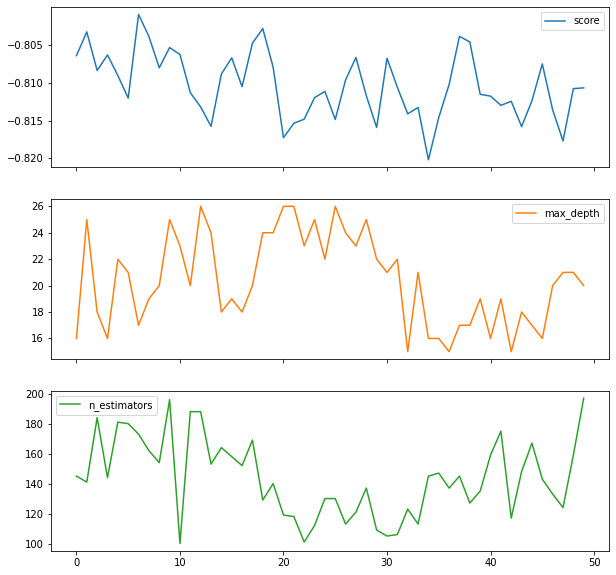

In [31]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

## Optuna

In [32]:
!pip install optuna
import optuna


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.5 MB/s eta 0:00:00


In [35]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [36]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2023-02-15 10:06:46,921] A new study created in memory with name: RandomForestClassifier
[I 2023-02-15 10:07:00,198] Trial 0 finished with value: 0.8071989062277097 and parameters: {'n_estimators': 133, 'max_depth': 24, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8071989062277097.
[I 2023-02-15 10:07:17,818] Trial 1 finished with value: 0.8079545015240697 and parameters: {'n_estimators': 175, 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8079545015240697.
[I 2023-02-15 10:07:26,102] Trial 2 finished with value: 0.8070258506727696 and parameters: {'n_estimators': 106, 'max_depth': 17, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8079545015240697.
[I 2023-02-15 10:07:38,631] Trial 3 finished with value: 0.8064447447448255 and parameters: {'n_estimators': 143, 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8079545015240697.
[I 2023-02-15 10:07:49,807] Trial 4 finished with value: 0.8040102064305129 and parameters: {'n_

CPU times: user 2min 31s, sys: 2.63 s, total: 2min 33s
Wall time: 13min


In [37]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 194, 'max_depth': 26, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.82


In [38]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print(f'Accuracy score on test data: {round(model.score(X_test, y_test), 2)}')
print(f'F-1 score on test data: {round(metrics.f1_score(y_test, y_test_pred), 2)}')

accuracy на тестовом наборе: 0.78
Accuracy score on test data: 0.78
F-1 score on test data: 0.8


50 iterations of Optuna also did not show best result.